In [1]:
import sys
sys.path.append('../')

from FeatureModels import *
from sklearn.ensemble import RandomForestRegressor

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2 

In [4]:
sensor = 's'
fill = '_fill'

district = 'Mean'

#savePath = 'Results/Results RF large periods_new.xlsx'

In [5]:
params = { 
    'n_estimators': np.linspace(10, 1000, 7).round().astype('int'),
    'max_features': np.linspace(0.1, 1, 5)
}
params

{'n_estimators': array([  10,  175,  340,  505,  670,  835, 1000]),
 'max_features': array([0.1  , 0.325, 0.55 , 0.775, 1.   ])}

## Модели, обученные за года

In [6]:
model = RandomForestRegressor(random_state = 100)

In [10]:
# Срез данных от begin до end
begin, end = '2019-01-01', '2024-03-19'

for season in ['winters', 'springs', 'summers', 'autumns']:
    ModelProcessing(model, sensor, fill, district, begin, end, seasonModel = '',  season_test = season, params = params, gridSearch = True, paramDependencies = [], plotRes = False, featImp = False)#, savePath = 'Results/Results RF large periods.xlsx')

,Train,CV,Test
"2019-01-01 — 2024-03-16 {'max_features': 0.55, 'n_estimators': 340}",,,
MSE,28.58,345.30,450.19
MAE,3.17,11.51,16.07
MAPE,0.20,0.80,0.56
R2,0.97,0.67,0.79


,Train,CV,Test
"2019-01-01 — 2024-03-16 {'max_features': 0.55, 'n_estimators': 340}",,,
MSE,28.58,345.30,74.03
MAE,3.17,11.51,6.44
MAPE,0.20,0.80,0.42
R2,0.97,0.67,0.56


,Train,CV,Test
"2019-01-01 — 2024-03-16 {'max_features': 0.55, 'n_estimators': 340}",,,
MSE,28.58,345.30,93.36
MAE,3.17,11.51,6.26
MAPE,0.20,0.80,0.86
R2,0.97,0.67,-0.08


,Train,CV,Test
"2019-01-01 — 2024-03-16 {'max_features': 0.55, 'n_estimators': 340}",,,
MSE,28.58,345.30,27.94
MAE,3.17,11.51,4.47
MAPE,0.20,0.80,0.58
R2,0.97,0.67,0.63


## Сезонные модели

,Train,CV,Test
"2019-01-01 — 2023-04-06 {'max_features': 0.55, 'n_estimators': 1000}",,,
MSE,74.03,783.56,498.96
MAE,5.98,19.62,17.38
MAPE,0.17,0.64,0.85
R2,0.97,0.64,0.76


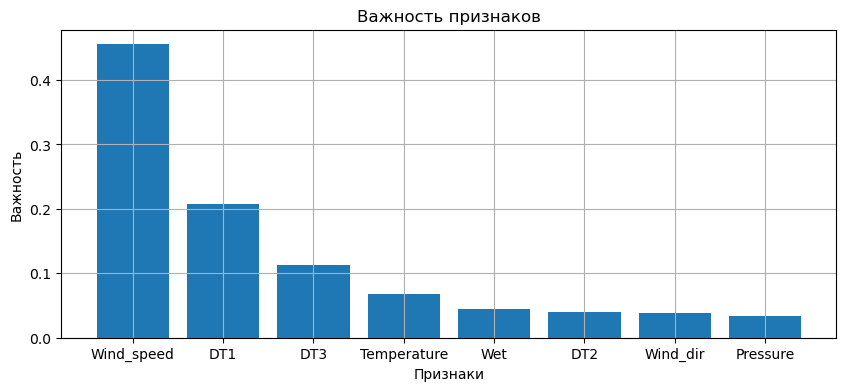

,Train,CV,Test
"2019-01-01 — 2023-04-06 {'max_features': 0.325, 'n_estimators': 505}",,,
MSE,6.89,70.77,55.39
MAE,1.93,6.36,5.59
MAPE,0.17,0.59,0.43
R2,0.94,0.43,0.67


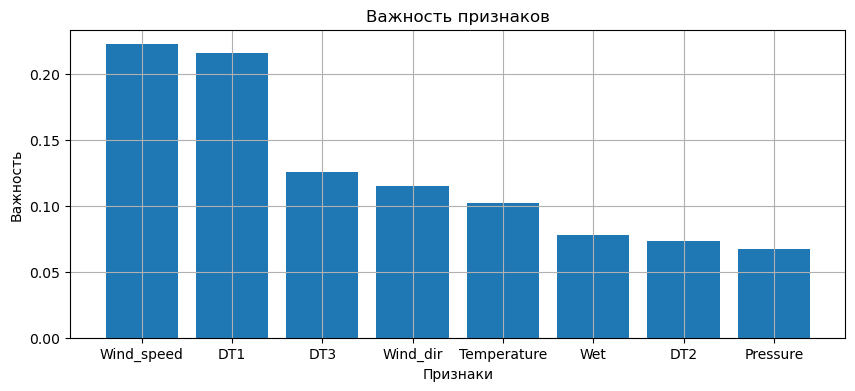

,Train,CV,Test
"2019-01-01 — 2023-04-06 {'max_features': 0.55, 'n_estimators': 340}",,,
MSE,2.49,21.27,103.96
MAE,1.18,3.59,6.39
MAPE,0.16,0.50,0.91
R2,0.92,0.27,-0.20


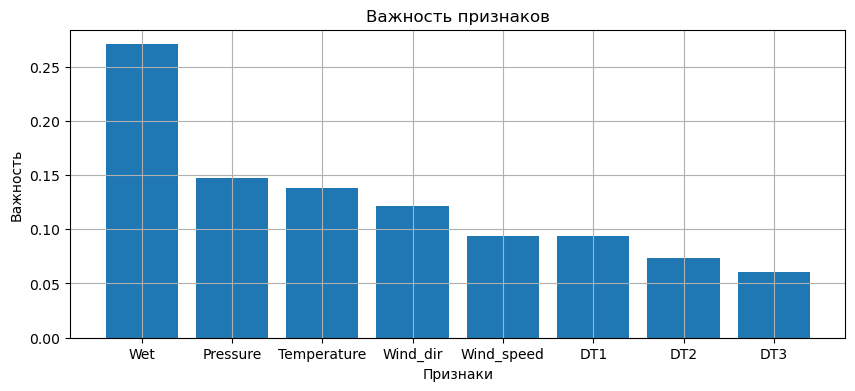

,Train,CV,Test
"2019-01-01 — 2023-04-06 {'max_features': 0.1, 'n_estimators': 1000}",,,
MSE,3.54,39.46,42.61
MAE,1.31,4.13,5.05
MAPE,0.17,0.51,0.61
R2,0.94,0.34,0.44


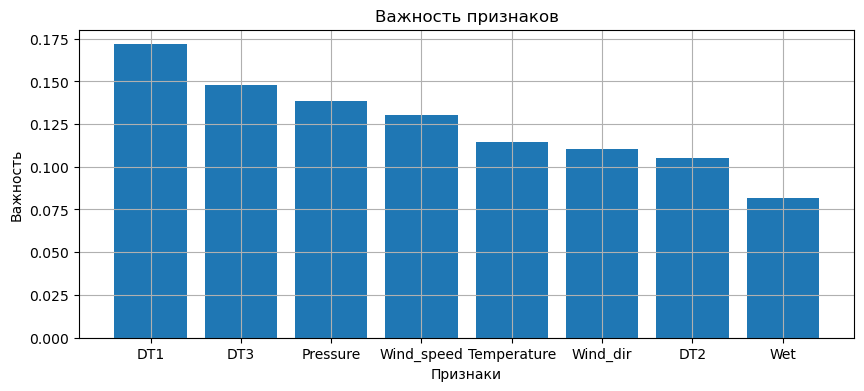

In [9]:
begin, end = '2019-01-01', '2024-03-19'

for season in ['winters', 'springs', 'summers', 'autumns']:
    ModelProcessing(model, sensor, fill, district, begin, end, seasonModel = season, season_test = season, params = params, gridSearch = True, paramDependencies = [], plotRes = False, featImp = True, savePath = 'Results/Results RF large periods_new.xlsx', sheet_name = 'По сезонам CV')